## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from multitask.benchmarks.kinetic_models import(
    StereoSelectiveReaction, 
    create_pcs_ds,
    MultitaskKinetics
)
from multitask.strategies import NewSTBO, NewMTBO
from multitask.utils import WandbRunner
from summit.utils.multiobjective import pareto_efficient
from summit import *
from botorch.optim import optimize_acqf, optimize_acqf_mixed
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import hiplot as hip
import wandb
from pathlib import Path
import torch
import json

## Stereo Selective Reaction

### Load Data

In [ ]:
#Constants
DATA_PATH   =  '../data/'
SOLVENT_DESCRIPTOR_DATA_FILE =  DATA_PATH + 'solvent_descriptors.csv'
SOLVENT_INDEX = 'cas_number'
SOLVENT_METADATA_VARIABLES = ['stenutz_name', 'cosmo_name', 'chemical_formula']
UCB_PHARMA_APPROVED_LIST = DATA_PATH + 'ucb_pharma_approved_list.csv'
SOLUBILITIES_DATA_FILE = DATA_PATH + "solvent_solubilities.csv"


#Load solvent descriptor dataset
_solvent_candidates = pd.read_csv(SOLVENT_DESCRIPTOR_DATA_FILE)
_solvent_candidates = _solvent_candidates.set_index(SOLVENT_INDEX)
solvent_ds = DataSet.from_df(_solvent_candidates, metadata_columns=SOLVENT_METADATA_VARIABLES)

#Load UCB Pharma approved list
ucb_list = pd.read_csv(UCB_PHARMA_APPROVED_LIST)
ucb_list = ucb_list.set_index('cas_number')
ucb_ds = DataSet.from_df(ucb_list, metadata_columns=['solvent_class', 'solvent_name'])

# Solubilities datset
solubilities = pd.read_csv(SOLUBILITIES_DATA_FILE)
solubilities = solubilities.set_index("cas_number")
solubilities = DataSet.from_df(solubilities)

### Descriptors

In [ ]:
solvent_ds_pcs, pca = create_pcs_ds(
    solvent_ds,
    ucb_ds,
    solubilities,
    num_components=3, 
    ucb_filter=True, 
    verbose=True
)

In [ ]:
pd.DataFrame(
    pca.components_.T, 
    index=solvent_ds.data_columns + ['solubility'], 
    columns=solvent_ds_pcs.data_columns
).sort_values('PC_1')

### Benchmark 

In [ ]:
random_state = np.random.RandomState(100)
exp = StereoSelectiveReaction(solvent_ds_pcs, random_state)
x = exp._integrate_rate('616-38-6', rxn_time=25200, step_size=100)

fig, axes = plt.subplots(1, 2, figsize=(10,5))
trange = np.linspace(0, 25400, x.shape[0])
cd1 = x[:, 0]
cd2 = x[:, 1]

axes[0].scatter(trange, 0.5-x[:,0]-x[:,1], label='ca/cb')
axes[0].scatter(trange, cd1, label='cd1')
axes[0].scatter(trange, cd2, label='cd2')
axes[0].legend(); axes[0].set_xlabel('Time (s)');
axes[0].set_ylabel('Concentration (mol/L)')

axes[1].scatter(trange, cd1/0.5*100, label='conversion')
axes[1].scatter(trange, cd1/(cd1+cd2)*100, label='de')
axes[1].legend(); axes[1].set_xlabel('Time (s)');
axes[1].set_ylabel('%')

In [ ]:
random_state = np.random.RandomState(100)
exp = StereoSelectiveReaction(solvent_ds_pcs, random_state)
conditions = DataSet(solvent_ds_pcs.index.values, columns=["solvent"])
all_experiments = exp.run_experiments(conditions) 

In [ ]:
all_experiments.sort_values("conversion")

In [ ]:
pareto, pareto_indices = pareto_efficient(
    all_experiments[["conversion", "de"]].to_numpy()
)
pareto = pd.DataFrame(pareto).sort_values(0).to_numpy()
ax = plt.subplot(111)
ax.set_xlabel('Conversion (%)'); ax.set_ylabel('DE (%)')
ax.scatter(all_experiments["conversion"], all_experiments["de"], marker='x')
ax.plot(pareto[:, 0], pareto[:, 1], c='y', label='pareto front')
ax.legend()
ax.tick_params(direction='in')
# plt.savefig('outputs/solvent_optimization_experiment_space.png')
# plt.savefig('outputs/solvent_optimization_experiment_space.svg')

### Optimization

In [ ]:
random_state = np.random.RandomState(100)
exp = StereoSelectiveReaction(
    solvent_ds_pcs.iloc[:50], random_state, use_descriptors=False
)
strategy = TSEMO(exp.domain, n_spectral_points=100)
r = Runner(strategy=strategy, experiment=exp, max_iterations=10, batch_size=10)
r.run()

In [ ]:
r.experiment.pareto_plot()

## Catalyst and Solvent Kinetic Network

Reaction:

Cat -> Pre-cat + Lig (k0) - Induction

SM1 + SM2 + Lig -> Product + Lig (k1) - main reaction

SM2 + SM2 + Lig -> Impurity1 + Lig (k2) - homocoupling

SM2 -> Impurity2 (k3) - side reaction (e.g., protodeboronation)

Product -> Impurity3 (k4)  - cleavage of product

Cat + Cat -> DeactiveCat (k4)

L1 90°C
Yield: 73.05%
Conversion SM1: 76.04%
Conversion SM2: 91.25%
Ligand yield: 100.00%


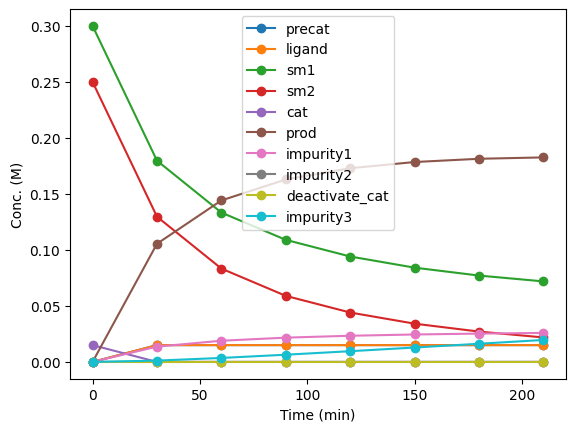

In [23]:
# ligands = ["L1", "L2", "L3", "L4"]
# solvents = ["S1", "S2", "S3", "S4"]

ligands = {
    # Best
    "L1": {
        "k": [2., 2., 0.5, 0.0015, 0.05, 0.05],
        "Ea": [30., 70., 70., 90., 85., 80.]
    },
    # Okay, forms less impurity1 but slower
    "L2": {
        "k": [2., 1., 0.05, 0.002, 0.005, 0.05],
        "Ea": [40., 70, 65, 90, 150, 80]
    },
    # Bad lots of impurity 1
    "L3": {
        "k": [2., 1., 2., 0.02, 0.005, 0.05],
        "Ea": [40., 40., 45., 80., 80., 80]
    },
    # Okay, forms lots of deactivated catalyst
    "L4": {
        "k": [2.0, 1., 0.01, 0.02, 4.0, 0.05],
        "Ea": [85., 50., 65., 80., 40., 80]
    },
    # Dead catalyst, nothing happens
    "L5": {
        "k": [2., 1e-3,1e-3,1e-3,1e-3, 0.05],
        "Ea": [40.,100.,100.,100.,100., 80]
    },
    # Almost dead catalyst
    "L6": {
        "k": [2., 0.1,1e-3,1e-3,1e-3, 0.05],
        "Ea": [40., 90.,100.,100.,100., 80,]
    },
    # Really slow catalyst, never gets past induction
    "L7": {
        "k": [0.001, 1e-4,1e-3,1e-3,1e-3, 0.05],
        "Ea": [70., 55,100.,100.,100., 80.]
    },
    # Slowish induction but otherwise good
    "L8": {
        "k": [0.001, 4., 0.5, 0.0015, 0.05, 0.05],
        "Ea": [60., 67., 70., 90., 85., 80.]
    },
}

solvents = {
    "S1": [1.0,1.5, 2., 1., 1., 0.8],  # Okay solvent, somewhat faster
    "S2": [1.0,2., 2., 5., 1., 1.], # Okay solvent, faster but hastens impurity 2 formation
    "S3": [1.0,4., 2., 1., 1., 0.5], # Best solvent, much faster
    "S4": [1.0,0.5, 0.5, 0.5, 0.5, 0.2], # Worst solvent, slows everything down
    "S5": [1.0,1.5, 2., 1.0, 1.5, 1.], # Okay solvent, accelerates catalyst deactivation
}

def rate(t, C, kV: list):
    # Concentrations
    precat = C[0]
    lig = C[1]
    sm1 = C[2]
    sm2 = C[3]
    cat = C[4]
    product = C[5]
    impurity_1 = C[6]
    impurity_2 = C[7]
    deactive_cat = C[8]
    impurity_3  = C[9]
    
    # Equations
    r = np.zeros(10)
    r[0] = kV[0]*cat
    r[1] = kV[0]*cat
    r[2] = -kV[1]*sm1*sm2*lig - kV[2]*sm1*sm2*lig 
    r[3] = -kV[1]*sm1*sm2*lig  - kV[2]*sm1*sm2*lig  - kV[3]*sm2
    r[4] = -kV[0]*cat-2*kV[4]*cat*cat 
    r[5] = kV[1]*sm1*sm2*lig - kV[5]*product
    r[6] = kV[2]*sm1*sm2*lig 
    r[7] = kV[3]*sm2
    r[8] = kV[4]*cat*cat
    r[9] = kV[5]*product
    return r
    

def react(
    ligand: str,
    solvent: str,
    temperature: float,
    res_time: float, 
    cat_conc: float,
    step_size: float = 15,
):
    # Constants
    C0 = [
        0.0, # Precat
        0.0, # Ligand
        0.3, #SM1
        0.25, #SM2
        0.003*cat_conc, #Catalyst
        0., #Product
        0., #impurity1
        0., #impurity2
        0., #deactivatecat
        0., #impurity3
    ]
    T = temperature + 273.15

    # Kinetic constants
    lig = ligands[ligand]
    k = lig["k"]
    Ea = lig["Ea"]
    AD = [7e9, 8.3e9, 8.5e9, 8e9, 8.8e9, 8e9]
    solvent_multipler = solvents[solvent]
    kV = [
        ADi*ki*np.exp(-Eai/(8.314e-3*T))
        for ADi, ki, Eai in zip(AD, k, Ea)
    ]
    kV = [
        kVi*solvent_multipler_i
        for kVi, solvent_multipler_i 
        in zip(kV, solvent_multipler)
    ]
    trange = np.arange(0, res_time, step_size)
    
    # Solve differential equation
    res = solve_ivp(
        rate,
        t_span=[0, res_time],
        y0=C0, 
        t_eval=trange,
        args=(kV,),
        method="LSODA",
    )
    return res.y.T

def run(
    ligand: str,
    solvent: str,
    temperature: float,
    res_time: float, 
    cat_conc: float,
    time_series: bool = True,
    step_size: float = 15,
):
    C = react(
        ligand=ligand, 
        solvent=solvent, 
        temperature=temperature, 
        res_time=res_time,
        cat_conc=cat_conc,
        step_size=step_size,
    )
    df = pd.DataFrame(
        C, 
        columns=[
            "precat",
            "ligand",
            "sm1",
            "sm2",
            "cat",
            "prod",
            "impurity1",
            "impurity2",
            "deactivate_cat",
            "impurity3",
        ]
    )
    trange = np.arange(0, res_time, step_size)
    df.index = trange
    return df

temp = 90
ligand= "L1"
df = run(
    ligand=ligand, 
    solvent="S3",
    temperature=temp,
    res_time=240, 
    cat_conc=5.0,
    step_size=30,
)
# print(1/(temp+273.15) + 1/303)
fig, ax = plt.subplots(1)
df.plot(marker="o", ax=ax)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Conc. (M)")
ax.legend(loc="upper center")
fig.savefig("ideal.png",dpi=300)

# Metrics
print(ligand, f"{temp}°C")
yld = df["prod"].iloc[-1]/df["sm2"].iloc[0] *100
print(f"Yield: {yld:0.02f}%" )
conv_sm1 = (df["sm1"].iloc[0]-df["sm1"].iloc[-1])/df["sm1"].iloc[0]*100
print(f"Conversion SM1: {conv_sm1:.02f}%")
conv_sm2 = (df["sm2"].iloc[0]-df["sm2"].iloc[-1])/df["sm2"].iloc[0]*100
print(f"Conversion SM2: {conv_sm2:.02f}%")
ligand_yld = df["ligand"].iloc[-1]/df["cat"].iloc[0]*100
print(f"Ligand yield: {ligand_yld:.02f}%")

L1 S3 85°C
Yield: 93.22%
Conversion SM1: 82.69%
Conversion SM2: 99.39%
Ligand yield: 98.14%


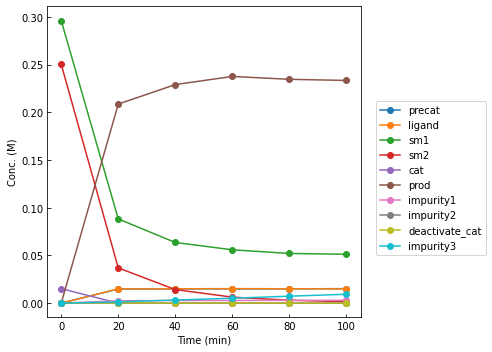

In [31]:
temp = 85
ligand= "L1"
solvent = "S3"
exp = MultitaskKinetics.load_yaml("case_1.yaml")
exp.noise_level = 1.0
df = exp._react(
    ligand=ligand, 
    solvent=solvent, 
    temperature=temp, 
    res_time=120,
    cat_conc=5.0,
    step_size=20,
)

# Plot
fig, ax = plt.subplots(1, figsize=(7,5))
df.plot(marker="o", ax=ax)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Conc. (M)")
leg = ax.legend( loc=(1.05, 0.2))
ax.tick_params(direction="in")

# Metrics
print(ligand, solvent, f"{temp}°C")
yld = df["prod"].iloc[-1]/df["sm2"].iloc[0] *100
print(f"Yield: {yld:0.02f}%" )
conv_sm1 = (df["sm1"].iloc[0]-df["sm1"].iloc[-1])/df["sm1"].iloc[0]*100
print(f"Conversion SM1: {conv_sm1:.02f}%")
conv_sm2 = (df["sm2"].iloc[0]-df["sm2"].iloc[-1])/df["sm2"].iloc[0]*100
print(f"Conversion SM2: {conv_sm2:.02f}%")
ligand_yld = df["ligand"].iloc[-1]/df["cat"].iloc[0]*100
print(f"Ligand yield: {ligand_yld:.02f}%")
fig.tight_layout()
fig.savefig(
    "../figures/multitask_kinetics_case_1.png", 
    dpi=300, 
    transparent=False,
    facecolor='white',
    bbox_extra_artists=(leg,),
)

In [8]:
exp.domain

Name,Type,Description,Values
ligand,"categorical, input",Ligand for catalyst complex,8 levels
solvent,"categorical, input",Reaction solvent,5 levels
temperature,"continuous, input",Reaction temperature in degrees Celsius,"[30,100]"
res_time,"continuous, input",Residence time in minutes,"[60,240]"
cat_conc,"continuous, input",Catalyst concentration,"[1,5]"
yld,"continuous, maximize objective",Reaction yield,"[0,100]"


L1 S1 85°C
Yield: 17.61%
Conversion SM1: 16.75%
Conversion SM2: 19.14%
Ligand yield: 100.66%


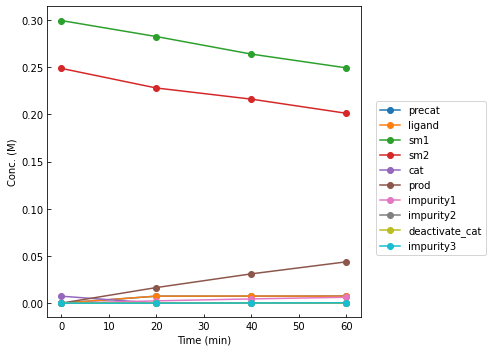

In [78]:
temp = 85
ligand= "L1"
solvent = "S1"
exp = MultitaskKinetics.load_yaml("case_2.yaml")
exp.noise_level = 1.0
df = exp._react(
    ligand=ligand, 
    solvent=solvent, 
    temperature=temp, 
    res_time=60,
    cat_conc=2.5,
    step_size=20,
)

# Plot
fig, ax = plt.subplots(1, figsize=(7,5))
df.plot(marker="o", ax=ax)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Conc. (M)")
leg = ax.legend( loc=(1.05, 0.2))
ax.tick_params(direction="in")

# Metrics
print(ligand, solvent, f"{temp}°C")
yld = df["prod"].iloc[-1]/df["sm2"].iloc[0] *100
print(f"Yield: {yld:0.02f}%" )
conv_sm1 = (df["sm1"].iloc[0]-df["sm1"].iloc[-1])/df["sm1"].iloc[0]*100
print(f"Conversion SM1: {conv_sm1:.02f}%")
conv_sm2 = (df["sm2"].iloc[0]-df["sm2"].iloc[-1])/df["sm2"].iloc[0]*100
print(f"Conversion SM2: {conv_sm2:.02f}%")
ligand_yld = df["ligand"].iloc[-1]/df["cat"].iloc[0]*100
print(f"Ligand yield: {ligand_yld:.02f}%")
fig.tight_layout()
fig.savefig(
    "../figures/multitask_kinetics_case_2.png", 
    dpi=300, 
    transparent=False,
    facecolor='white',
    bbox_extra_artists=(leg,),
)

L8 S1 85°C
Yield: 64.32%
Conversion SM1: 83.39%
Conversion SM2: 100.00%
Ligand yield: 76.58%


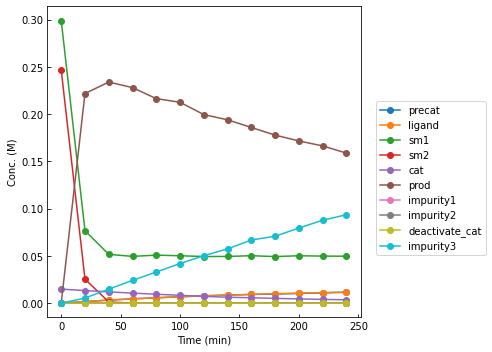

In [79]:
temp = 85
ligand= "L8"
solvent = "S1"
exp = MultitaskKinetics.load_yaml("case_2.yaml")
exp.noise_level = 1.0
df = exp._react(
    ligand=ligand, 
    solvent=solvent, 
    temperature=temp, 
    res_time=240,
    cat_conc=5.0,
    step_size=20,
)

# Plot
fig, ax = plt.subplots(1, figsize=(7,5))
df.plot(marker="o", ax=ax)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Conc. (M)")
leg = ax.legend( loc=(1.05, 0.2))
ax.tick_params(direction="in")

# Metrics
print(ligand, solvent, f"{temp}°C")
yld = df["prod"].iloc[-1]/df["sm2"].iloc[0] *100
print(f"Yield: {yld:0.02f}%" )
conv_sm1 = (df["sm1"].iloc[0]-df["sm1"].iloc[-1])/df["sm1"].iloc[0]*100
print(f"Conversion SM1: {conv_sm1:.02f}%")
conv_sm2 = (df["sm2"].iloc[0]-df["sm2"].iloc[-1])/df["sm2"].iloc[0]*100
print(f"Conversion SM2: {conv_sm2:.02f}%")
ligand_yld = df["ligand"].iloc[-1]/df["cat"].iloc[0]*100
print(f"Ligand yield: {ligand_yld:.02f}%")
fig.tight_layout()
fig.savefig(
    "../figures/multitask_kinetics_case_2_bad.png", 
    dpi=300, 
    transparent=False,
    facecolor='white',
    bbox_extra_artists=(leg,),
)

### Single-Task Case 1

In [ ]:
config ={
    "benchmark_type": "Benchmark.kinetics",
    "model_name": "multitask_kinetics_case_1",
    "wandb_artifact_name": "stbo_kinetics_case_1",
    "output_path": "data/single_task/stbo_kinetics_case_1",
    "acquisition_function": "EI",
    "brute_force_categorical": False,
    "batch_size": 1,
    "max_experiments": 20
}
output_path = Path(config["output_path"])
output_path.mkdir(exist_ok=True, parents=True)
for i in range(20):
    run = wandb.init(
        entity="ceb-sre", 
        project="multitask", 
        tags=["kinetics"],
        config=config,
    )
    exp = MultitaskKinetics.load_yaml("case_1.yaml")
    strategy = NewSTBO(
        exp.domain,
        # categorical_method=None,
        # brute_force_categorical=True,
        acquisition_function=config["acquisition_function"],
    )
    r = WandbRunner(
        strategy=strategy, 
        experiment=exp, 
        max_iterations=config["max_experiments"],
    )
    r.run(skip_wandb_intialization=True)
    
    # Save
    r.save(output_path / f"repeat_{i}.json")
    torch.save(
        r.strategy.model.state_dict(),
        output_path / f"repeat_{i}_model.pth",
    )
    artifact = wandb.Artifact(
        config["wandb_artifact_name"], type="optimization_result"
    )
    artifact.add_file(output_path / f"repeat_{i}.json")
    artifact.add_file(output_path / f"repeat_{i}_model.pth")
    run.log_artifact(artifact)
    run.finish()

/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: Performance

iteration,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
yld_best,▁▁▁▁▂▂▃▄▄▅▅▅▅███████
iteration,19
yld_best,55.11309


/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: Performance

<AxesSubplot: >

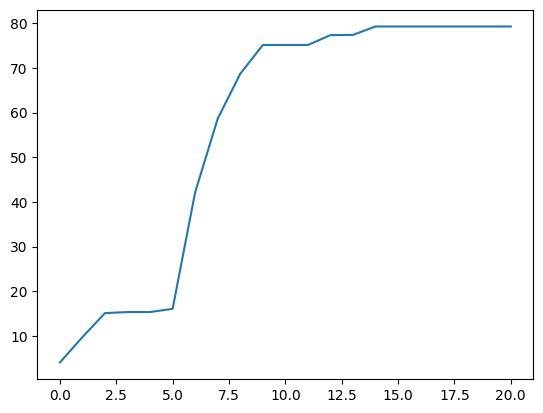

In [7]:
exp.data["yld"].cummax().plot()

In [8]:
exp.data

,ligand,solvent,temperature,res_time,cat_conc,yld,computation_t,experiment_t,strategy
0,L2,S3,47.5,105.0,4.0,4.02602,0.0,0.004403,LHS
1,L8,S2,82.5,195.0,2.0,9.710508,0.0,0.003031,LHS
2,L8,S2,96.462897,220.041851,1.02855,15.086684,9.212517,0.003746,STBO
3,L8,S2,100.0,177.127148,1.0,15.321682,5.151505,0.003649,STBO
4,L8,S2,100.0,103.193561,1.0,8.768497,4.635681,0.003397,STBO
5,L8,S2,100.0,201.619265,1.0,16.04403,8.74753,0.003779,STBO
6,L3,S2,100.0,225.975239,1.0,42.163482,1.516075,0.006932,STBO
7,L3,S2,85.723454,240.0,1.0,58.642303,7.923351,0.006904,STBO
8,L3,S2,74.642236,240.0,1.0,68.700366,8.020901,0.006613,STBO
9,L3,S2,60.927045,240.0,1.0,75.13603,5.686932,0.006578,STBO


In [9]:
exp.domain

Name,Type,Description,Values
ligand,"categorical, input",Ligand for catalyst complex,8 levels
solvent,"categorical, input",Reaction solvent,5 levels
temperature,"continuous, input",Reaction temperature in degrees Celsius,"[30,100]"
res_time,"continuous, input",Residence time in minutes,"[60,240]"
cat_conc,"continuous, input",Catalyst concentration,"[1,5]"
yld,"continuous, maximize objective",Reaction yield,"[0,100]"


In [10]:
strategy.model.covar_module.base_kernel.lengthscale[0][:8]

tensor([0.3334, 0.3333, 0.3285, 0.3334, 0.3334, 0.3334, 0.3334, 0.3285],
       device='cuda:0', dtype=torch.float64, grad_fn=<SliceBackward0>)

In [11]:
strategy.model.covar_module.base_kernel.lengthscale[0][8:13]

tensor([0.3334, 0.3333, 0.3333, 0.3334, 0.3334], device='cuda:0',
       dtype=torch.float64, grad_fn=<SliceBackward0>)

L8 85°C
Yield: 79.02%
Conversion SM1: 83.60%
Conversion SM2: 100.00%
Ligand yield: 94.79%


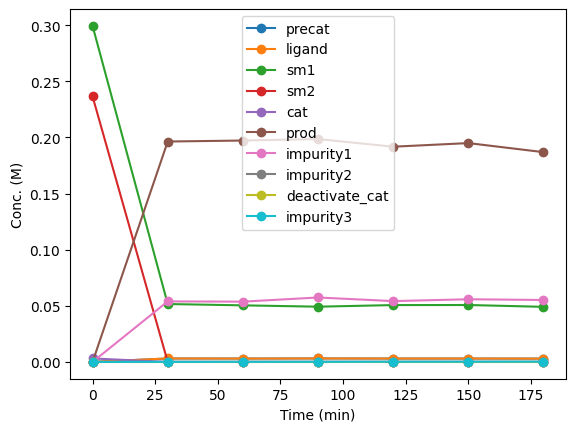

In [12]:
exp.data["yld"] = exp.data["yld"].astype(float)
best = exp.data.iloc[exp.data["yld"].argmax()]
df = exp._react(
    ligand=str(best["ligand"].values[0]), 
    solvent=str(best["solvent"].values[0]), 
    temperature=float(best["temperature"]), 
    res_time=float(best["res_time"]),
    cat_conc=float(best["cat_conc"]),
    step_size=30,
)

# Plot
fig, ax = plt.subplots(1)
df.plot(marker="o", ax=ax)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Conc. (M)")
ax.legend(loc="upper center")

# Metrics
print(ligand, f"{temp}°C")
yld = df["prod"].iloc[-1]/df["sm2"].iloc[0] *100
print(f"Yield: {yld:0.02f}%" )
conv_sm1 = (df["sm1"].iloc[0]-df["sm1"].iloc[-1])/df["sm1"].iloc[0]*100
print(f"Conversion SM1: {conv_sm1:.02f}%")
conv_sm2 = (df["sm2"].iloc[0]-df["sm2"].iloc[-1])/df["sm2"].iloc[0]*100
print(f"Conversion SM2: {conv_sm2:.02f}%")
ligand_yld = df["ligand"].iloc[-1]/df["cat"].iloc[0]*100
print(f"Ligand yield: {ligand_yld:.02f}%")

### Single-Task Case 2

In [4]:
config ={
    "benchmark_type": "Benchmark.kinetics",
    "model_name": "multitask_kinetics_case_2",
    "wandb_artifact_name": "stbo_kinetics_case_2",
    "output_path": "data/single_task/stbo_kinetics_case_2",
    "acquisition_function": "EI",
    "brute_force_categorical": False,
    "batch_size": 1,
    "max_experiments": 96
}
output_path = Path(config["output_path"])
output_path.mkdir(exist_ok=True, parents=True)
run = wandb.init(
    entity="ceb-sre", 
    project="multitask", 
    tags=["kinetics"],
    config=config,
)
exp_ct = MultitaskKinetics.load_yaml("case_2.yaml")
strategy = NewSTBO(
    exp_ct.domain,
    # categorical_method=None,
    # brute_force_categorical=True,
    acquisition_function=config["acquisition_function"],
)
r = WandbRunner(
    strategy=strategy, 
    experiment=exp_ct, 
    max_iterations=config["max_experiments"],
)
r.run(skip_wandb_intialization=True)

# Save
i=0
r.save(output_path / f"repeat_{i}.json")
torch.save(
    r.strategy.model.state_dict(),
    output_path / f"repeat_{i}_model.pth",
)
artifact = wandb.Artifact(
    config["wandb_artifact_name"], type="optimization_result"
)
artifact.add_file(output_path / f"repeat_{i}.json")
artifact.add_file(output_path / f"repeat_{i}_model.pth")
run.log_artifact(artifact)
run.finish()
ct_data = exp_ct.data

wandb: Currently logged in as: marcosfelt (ceb-sre). Use `wandb login --relogin` to force relogin


/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/multitask/strategies/st.py:281: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  return torch.tensor(bounds, dtype=dtype, device=self.device).T
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a l

iteration,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
yld_best,▁▃▃▄▄▄▄▄▄▄▄▄▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█
iteration,95
yld_best,99.4222


<AxesSubplot: >

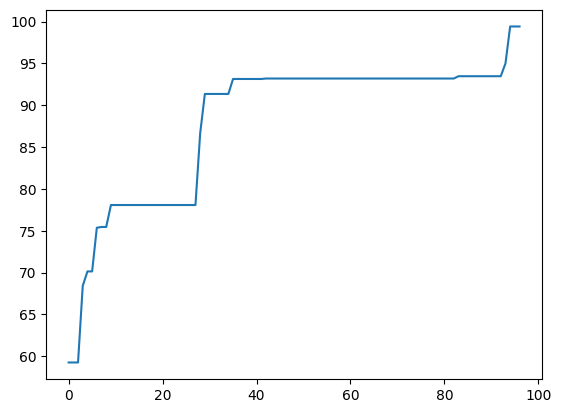

In [5]:
exp_ct.data["yld"].cummax().plot()

Best conditions:
NAME           TYPE    
ligand         DATA               L8
solvent        DATA               S2
temperature    DATA        49.019417
res_time       DATA            240.0
cat_conc       DATA              5.0
yld            DATA        99.422198
computation_t  METADATA     7.103184
experiment_t   METADATA     0.004174
strategy       METADATA         STBO
task           METADATA            0
Name: 94, dtype: object
Yield: 98.12%
Conversion SM1: 81.03%
Conversion SM2: 97.19%
Ligand yield: 13.34%


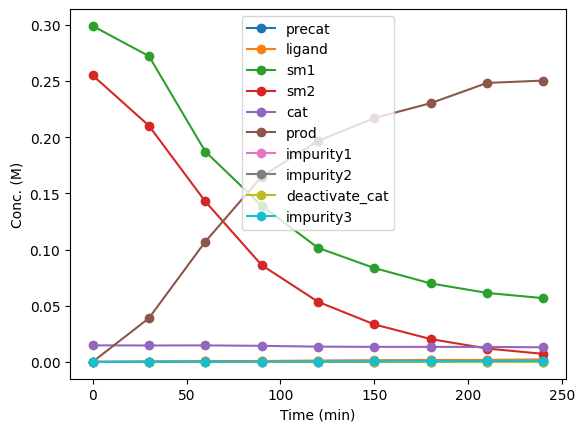

In [8]:
ct_data["yld"] = ct_data["yld"].astype(float)
best = ct_data.iloc[ct_data["yld"].argmax()]
print("Best conditions:")
print(best)
df = exp_ct._react(
    ligand=str(best["ligand"].values[0]), 
    solvent=str(best["solvent"].values[0]), 
    temperature=float(best["temperature"]), 
    res_time=float(best["res_time"]),
    cat_conc=float(best["cat_conc"]),
    step_size=30,
)

# Plot
fig, ax = plt.subplots(1)
df.plot(marker="o", ax=ax)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Conc. (M)")
ax.legend(loc="upper center")
fig.savefig("multitask_kinetics_case_2_stbo_best.png", dpi=300)

# Metrics
# print(ligand, f"{temp}°C")
yld = df["prod"].iloc[-1]/df["sm2"].iloc[0] *100
print(f"Yield: {yld:0.02f}%" )
conv_sm1 = (df["sm1"].iloc[0]-df["sm1"].iloc[-1])/df["sm1"].iloc[0]*100
print(f"Conversion SM1: {conv_sm1:.02f}%")
conv_sm2 = (df["sm2"].iloc[0]-df["sm2"].iloc[-1])/df["sm2"].iloc[0]*100
print(f"Conversion SM2: {conv_sm2:.02f}%")
ligand_yld = df["ligand"].iloc[-1]/df["cat"].iloc[0]*100
print(f"Ligand yield: {ligand_yld:.02f}%")

### Multi-task Case 1

In [10]:
api = wandb.Api()
artifact = api.artifact('ceb-sre/multitask/stbo_kinetics_case_2:latest')
artifact_path = artifact.download()
artifact_path = Path(artifact_path)

wandb:   2 of 2 files downloaded.  


In [11]:
with open (artifact_path / "repeat_0.json", "r") as f:
    d = json.load(f)

ct_data = DataSet.from_dict(d["experiment"]["data"])
ct_data["task", "METADATA"] = 0

/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: Performance

iteration,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
yld_best,▁▁▁▁▂▂▂▇▇███████████
cat_conc_best,5.0
computation_t_best,11.15935
experiment_t_best,0.00662
iteration,19
ligand_best,L1
res_time_best,240.0
solvent_best,S4
strategy_best,MTBO
task_best,1


/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: Performance

iteration,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
yld_best,▁▁▁▇▇▇▇▇▇▇▇█████████
cat_conc_best,5.0
computation_t_best,3.67269
experiment_t_best,0.00635
iteration,19
ligand_best,L1
res_time_best,60.0
solvent_best,S3
strategy_best,MTBO
task_best,1


/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: Performance

iteration,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
yld_best,▁▁▁▁▁▁▁▁▁▆▆▇▇▇▇█████
cat_conc_best,1.90855
computation_t_best,5.72554
experiment_t_best,0.00651
iteration,19
ligand_best,L3
res_time_best,135.49768
solvent_best,S3
strategy_best,MTBO
task_best,1


/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: Performance

iteration,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
yld_best,▁▁▁▁▁▆▇▇▇▇▇█████████
cat_conc_best,5.0
computation_t_best,5.56712
experiment_t_best,0.00677
iteration,19
ligand_best,L3
res_time_best,60.0
solvent_best,S3
strategy_best,MTBO
task_best,1


/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: Performance

iteration,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
yld_best,▁▁▁▃▃▆▆▆▆▆▆▆▆▇▇▇▇███
cat_conc_best,1.34569
computation_t_best,5.71234
experiment_t_best,0.00629
iteration,19
ligand_best,L3
res_time_best,148.26902
solvent_best,S3
strategy_best,MTBO
task_best,1


/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: Performance

iteration,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
yld_best,▁▁▁▁▆███████████████
cat_conc_best,5.0
computation_t_best,11.88077
experiment_t_best,0.00667
iteration,19
ligand_best,L3
res_time_best,60.0
solvent_best,S3
strategy_best,MTBO
task_best,1


/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: Performance

iteration,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
yld_best,▁▁▁▁▁▂▂█████████████
cat_conc_best,5.0
computation_t_best,5.81036
experiment_t_best,0.0072
iteration,19
ligand_best,L1
res_time_best,240.0
solvent_best,S4
strategy_best,MTBO
task_best,1


/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: Performance

iteration,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
yld_best,▁▁▁█████████████████
cat_conc_best,5.0
computation_t_best,4.78034
experiment_t_best,0.00681
iteration,19
ligand_best,L3
res_time_best,60.0
solvent_best,S3
strategy_best,MTBO
task_best,1


/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: Performance

iteration,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
yld_best,▁▁▁▁▁▁▁▇▇▇▇▇▇███████
cat_conc_best,5.0
computation_t_best,5.91661
experiment_t_best,0.00676
iteration,19
ligand_best,L3
res_time_best,240.0
solvent_best,S3
strategy_best,MTBO
task_best,1


/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: Performance

iteration,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
yld_best,▁▁▁▃▃▃▃▇▇▇▇▇▇███████
cat_conc_best,5.0
computation_t_best,10.53134
experiment_t_best,0.00642
iteration,19
ligand_best,L1
res_time_best,110.43196
solvent_best,S3
strategy_best,MTBO
task_best,1


/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: Performance

iteration,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
yld_best,▁▁▁▁▁▁▇▇▇▇▇▇████████
cat_conc_best,5.0
computation_t_best,6.16413
experiment_t_best,0.00658
iteration,19
ligand_best,L3
res_time_best,60.0
solvent_best,S3
strategy_best,MTBO
task_best,1


/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: Performance

iteration,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
yld_best,▁▁▁▁▁▁██████████████
cat_conc_best,5.0
computation_t_best,4.73694
experiment_t_best,0.00624
iteration,19
ligand_best,L1
res_time_best,60.0
solvent_best,S3
strategy_best,MTBO
task_best,1


/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: Performance

iteration,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
yld_best,▁▁▁▁▁▁▁▁▁▁▇▇▇▇▇█████
cat_conc_best,5.0
computation_t_best,5.71828
experiment_t_best,0.00655
iteration,19
ligand_best,L3
res_time_best,60.0
solvent_best,S3
strategy_best,MTBO
task_best,1


/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: Performance

iteration,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
yld_best,▁▂▂▃▃▃▃▆▆▆▇█████████
cat_conc_best,5.0
computation_t_best,3.81131
experiment_t_best,0.00627
iteration,19
ligand_best,L1
res_time_best,60.0
solvent_best,S3
strategy_best,MTBO
task_best,1


/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: Performance

iteration,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
yld_best,▁▂▂▂▂▆▆▆▆▇██████████
cat_conc_best,5.0
computation_t_best,14.57582
experiment_t_best,0.00622
iteration,19
ligand_best,L1
res_time_best,60.0
solvent_best,S3
strategy_best,MTBO
task_best,1


/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: Performance

iteration,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
yld_best,▁▁▁▁▁▁▁▁▂▇▇▇▇▇▇█████
cat_conc_best,1.0
computation_t_best,6.77356
experiment_t_best,0.00681
iteration,19
ligand_best,L3
res_time_best,156.71956
solvent_best,S3
strategy_best,MTBO
task_best,1


/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: Performance

iteration,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
yld_best,▁▁▁▁▂▅▅▆▇███████████
cat_conc_best,5.0
computation_t_best,5.15748
experiment_t_best,0.0064
iteration,19
ligand_best,L1
res_time_best,240.0
solvent_best,S3
strategy_best,MTBO
task_best,1


/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: Performance

iteration,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
yld_best,▁▂▂█████████████████
cat_conc_best,5.0
computation_t_best,6.16134
experiment_t_best,0.00665
iteration,19
ligand_best,L1
res_time_best,240.0
solvent_best,S4
strategy_best,MTBO
task_best,1


/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(variable.name, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:334: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_ds = new_ds.drop(one_hot_names, axis=1)
/content/venv/lib/python3.8/site-packages/summit/strategies/base.py:162: Performance

iteration,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
yld_best,▁▁▁▁▁▁▂▂▂▇▇▇▇▇▇█████
cat_conc_best,1.70014
computation_t_best,5.85127
experiment_t_best,0.00646
iteration,19
ligand_best,L3
res_time_best,136.9647
solvent_best,S3
strategy_best,MTBO
task_best,1


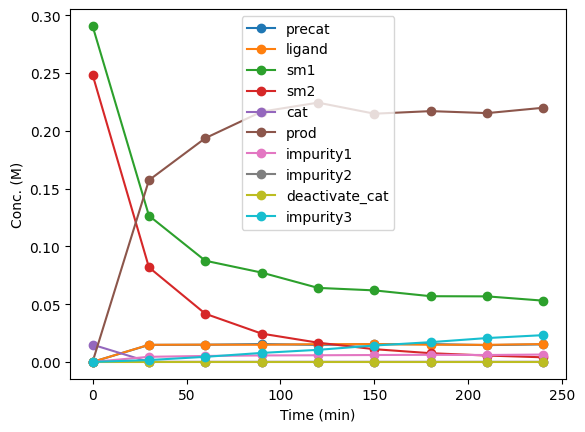

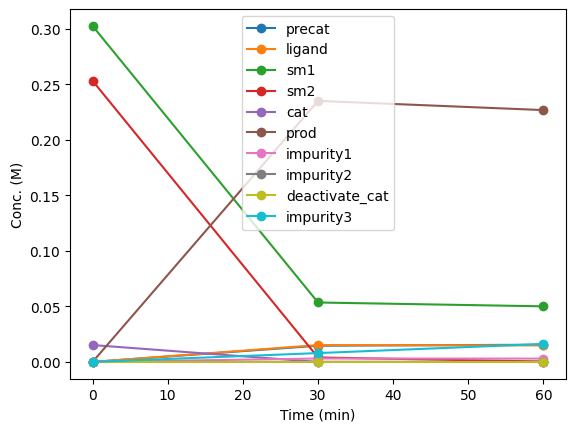

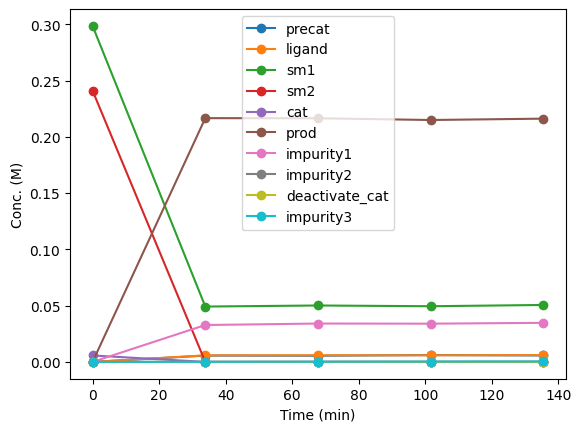

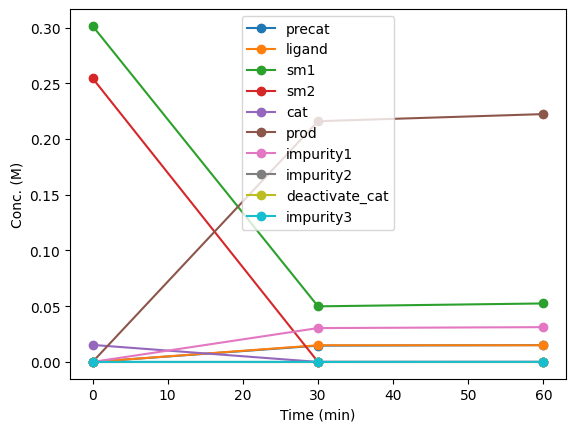

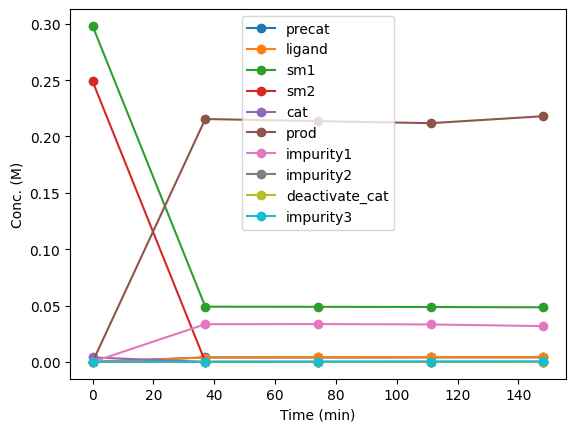

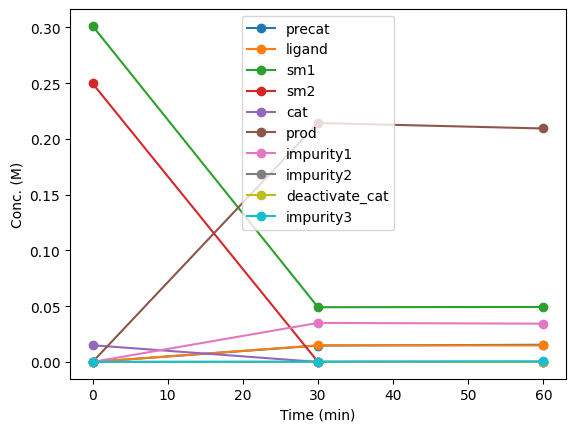

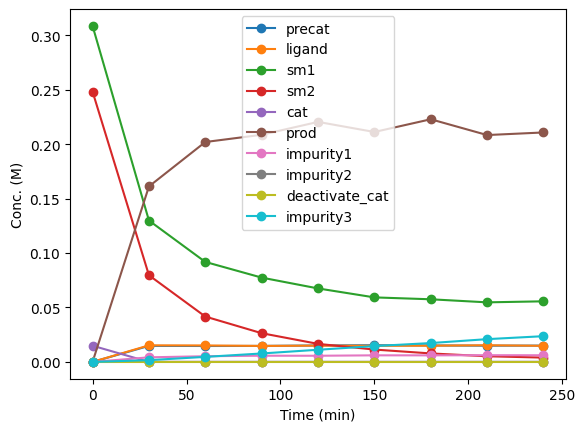

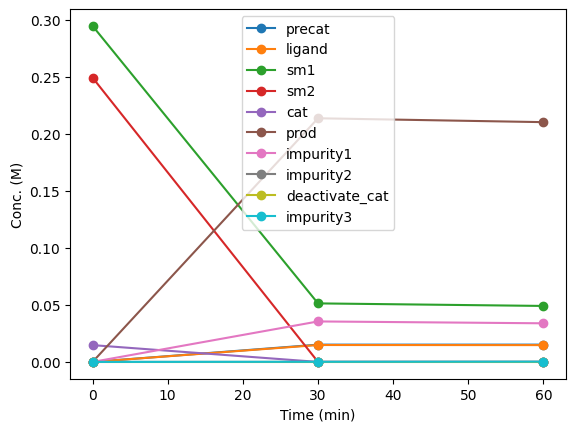

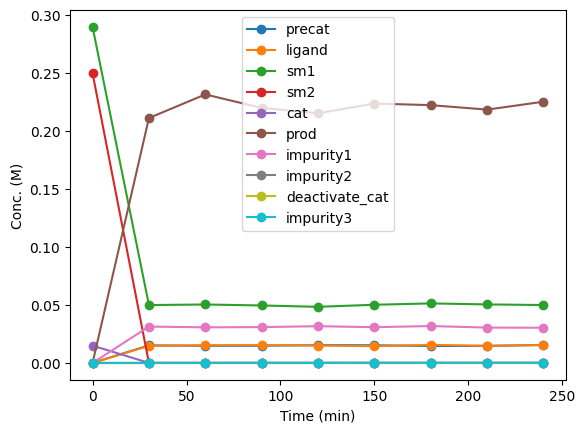

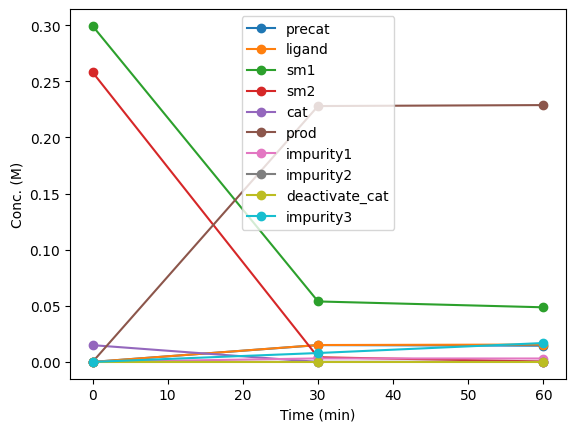

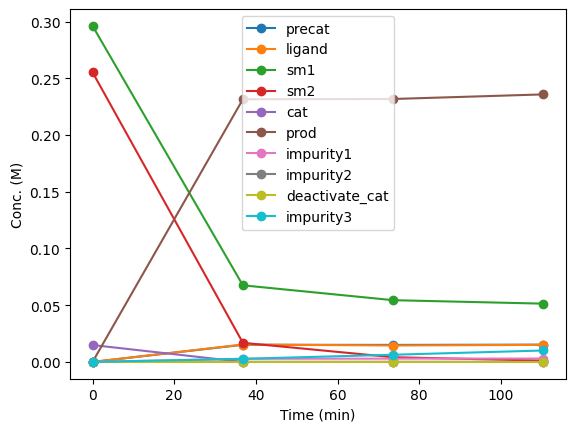

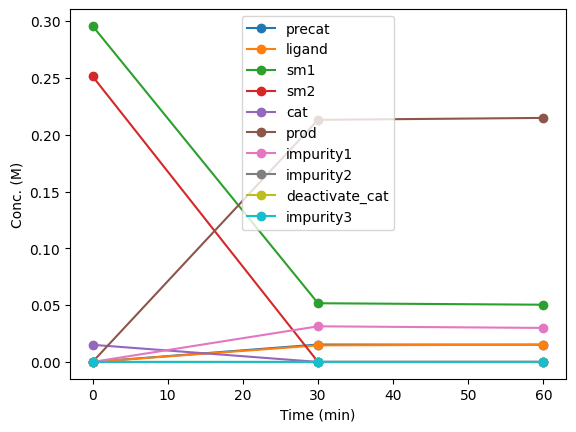

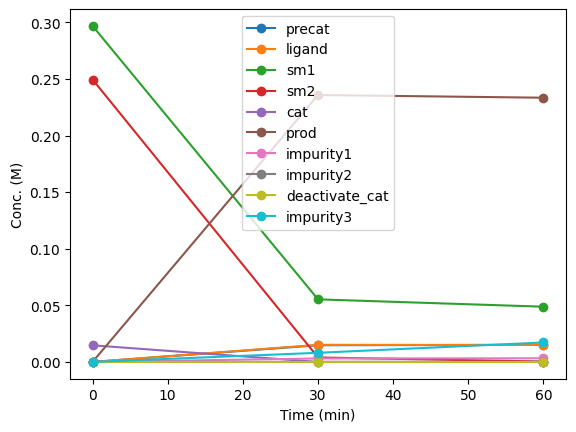

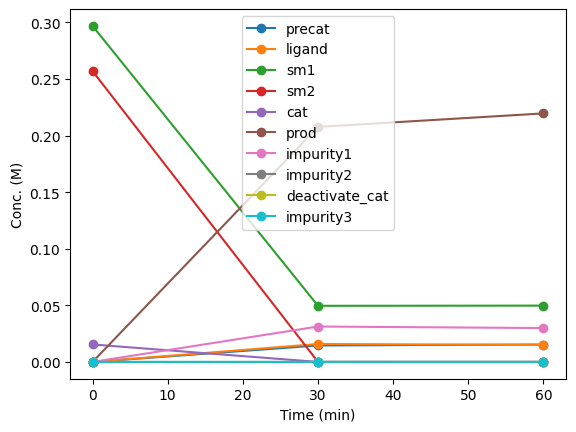

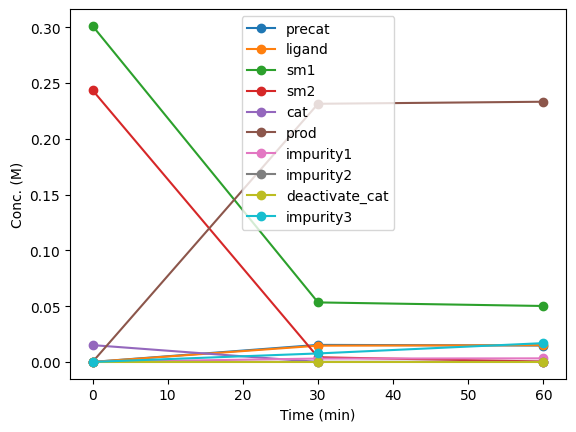

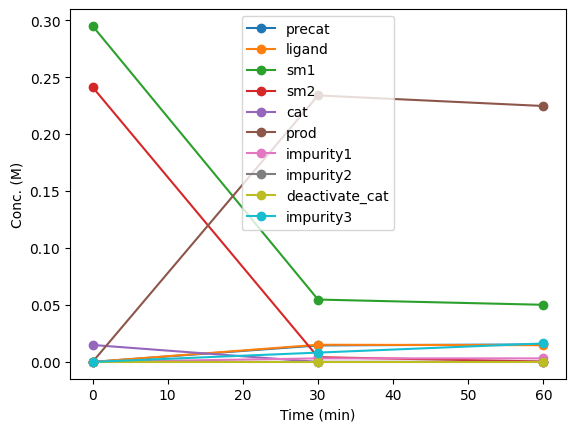

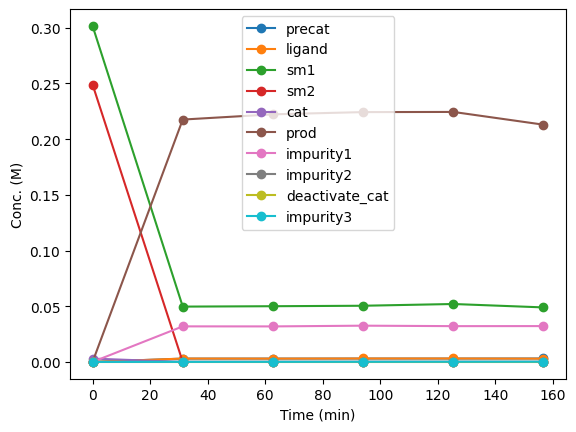

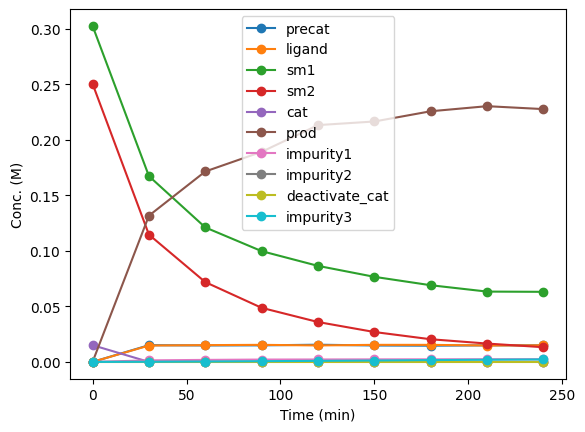

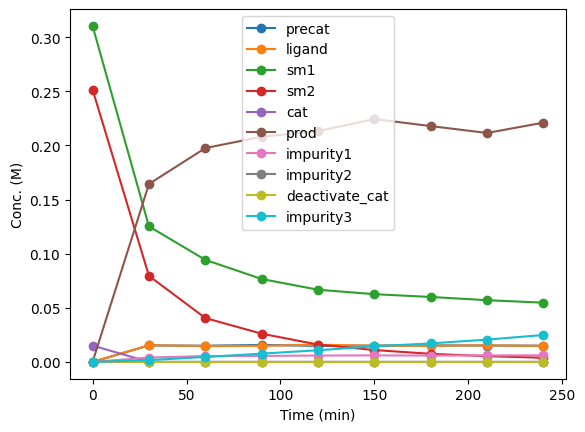

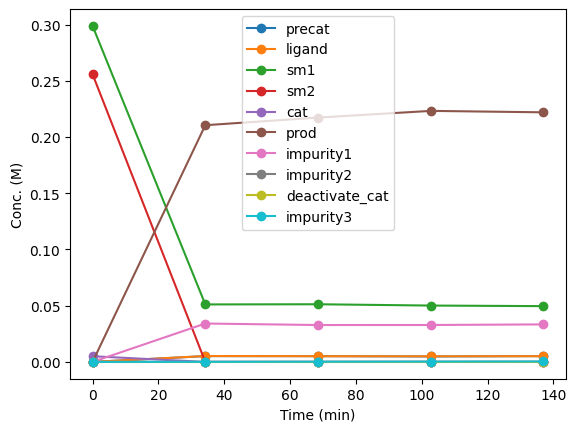

In [12]:
config ={
    "benchmark_type": "Benchmark.kinetics",
    "model_name": "multitask_kinetics_case_1",
    "wandb_artifact_name": "mtbo_kinetics_case_1",
    "output_path": "data/multitask_task/mtbo_kinetics_case_1",
    "acquisition_function": "EI",
    "brute_force_categorical": False,
    "batch_size": 1,
    "max_experiments": 20,
    "strategy": "MTBO"
}
output_path = Path(config["output_path"])
output_path.mkdir(exist_ok=True, parents=True)
for i in range(20):
    run = wandb.init(
        entity="ceb-sre", 
        project="multitask", 
        tags=["kinetics", "MTBO", "HS"],
        config=config,
    )
    exp = MultitaskKinetics.load_yaml("case_1.yaml")
    
    # Get best initial conditions
    conditions = ct_data.sort_values(by="yld", ascending=False).iloc[0]
    conditions = conditions.drop(columns=["yld", "task"]).to_frame().T
    prev_res = exp.run_experiments(conditions)
    prev_res["task", "METADATA"] = 1
    
    # Run optimization
    
    strategy = NewMTBO(
        exp.domain,
        pretraining_data=ct_data,
        task=1,
        acquisition_function=config["acquisition_function"],
    )
    r = WandbRunner(
        strategy=strategy, 
        experiment=exp, 
        max_iterations=config["max_experiments"],
    )
    r.run(skip_wandb_intialization=True, prev_res=prev_res)
    
    # Get best conditions
    data = exp.data
    data["yld"] = data["yld"].astype(float)
    best = data.iloc[data["yld"].argmax()]
    for (name, typ), val in best.items():
        wandb.summary[f"{name}_best"] = val
    df = exp._react(
        ligand=str(best["ligand"].values[0]), 
        solvent=str(best["solvent"].values[0]), 
        temperature=float(best["temperature"]), 
        res_time=float(best["res_time"]),
        cat_conc=float(best["cat_conc"]),
        step_size=30,
    )

    # Plot
    fig, ax = plt.subplots(1)
    df.plot(marker="o", ax=ax)
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Conc. (M)")
    ax.legend(loc="upper center")
    fig_path = output_path / "multitask_kinetics_case_1_stbo_best.png"
    fig.savefig(fig_path, dpi=300)
    wandb.log({"reaction": wandb.Image(fig)})
    
    # Save
    r.save(output_path / f"repeat_{i}.json")
    torch.save(
        r.strategy.model.state_dict(),
        output_path / f"repeat_{i}_model.pth",
    )
    artifact = wandb.Artifact(
        config["wandb_artifact_name"], type="optimization_result"
    )
    artifact.add_file(output_path / f"repeat_{i}.json")
    artifact.add_file(output_path / f"repeat_{i}_model.pth")
    artifact.add_file(fig_path)
    run.log_artifact(artifact)
    run.finish()

### Acquisition Functions Exploration

In [65]:
api = wandb.Api()
artifact = api.artifact('ceb-sre/multitask/stbo_kinetics_case_2:v0')
artifact_path = artifact.download()
artifact_path = Path(artifact_path)

In [66]:
import json
with open (artifact_path / "repeat_0.json", "r") as f:
    d = json.load(f)

ct_data = DataSet.from_dict(d["experiment"]["data"])
ct_data["task", "METADATA"] = 0

In [67]:
# Get best initial conditions
conditions = ct_data.sort_values(by="yld", ascending=False).iloc[0]
conditions = conditions.drop(columns=["yld", "task"]).to_frame().T
prev_res = exp.run_experiments(conditions).copy()
prev_res["task", "METADATA"] = 1

In [71]:
exp = MultitaskKinetics.load_yaml("case_2.yaml")
strategy = NewMTBO(
    exp.domain,
    pretraining_data=ct_data, 
    acquisition_function="EI",
    brute_force_categorical=False,
#     model_type=NewMTBO.LCM,
)
r = Runner(strategy=strategy, experiment=exp, max_iterations=5)
r.run(prev_res=prev_res)

In [72]:
cur = 0
lengthscales = strategy.model.covar_module.base_kernel.lengthscale.detach().squeeze().numpy()
for v in exp.domain.input_variables:
    if isinstance(v, ContinuousVariable):
        print(f"{v.name}: {lengthscales[cur]:.02f}")
        cur += 1
    elif isinstance(v, CategoricalVariable):
        print(v.name)
        for level in v.levels:
            print(f"\t{level}: {lengthscales[cur]:.02f}")
            cur += 1


ligand
	L1: 0.32
	L2: 0.34
	L3: 0.28
	L4: 0.34
	L5: 0.34
	L6: 0.34
	L7: 0.34
	L8: 0.34
solvent
	S1: 0.82
	S2: 1.02
	S3: 1.22
	S4: 0.99
	S5: 0.98
temperature: 0.67
res_time: 1.33
cat_conc: 1.91


In [73]:
strategy.all_experiments

,ligand,solvent,temperature,res_time,cat_conc,yld,computation_t,experiment_t,strategy,task
34,L1,S3,64.798976,220.884127,5.0,11.063264,5129.098397,0.003416,STBO,1
0,L5,S1,39.820735,64.436314,1.145804,0.157528,0.0,0.003622,MTBO,1
0,L6,S2,75.36697,126.201102,2.45754,3.787405,0.924107,0.002603,MTBO,1
0,L7,S4,96.963606,219.955898,3.897089,0.078756,0.995562,0.001791,MTBO,1
0,L3,S3,34.146429,198.965579,1.273732,71.869173,1.080329,0.004174,MTBO,1


In [74]:
inputs, output = strategy.transform.transform_inputs_outputs(
    pd.concat([exp.data, ct_data]),
    categorical_method="one-hot",
    min_max_scale_inputs=True,
    standardize_outputs=True,
)
candidates, acq_values= optimize_acqf(
    acq_function=strategy.acq,
    bounds=strategy._get_bounds(),
    num_restarts=100,
    q=1,
    raw_samples=2000,
    return_best_only=False
)
candidates = candidates.squeeze()

In [75]:
res = DataSet(candidates.numpy(), columns=inputs.data_columns)
X = strategy.transform.un_transform(
    res,
    categorical_method="one-hot",
    min_max_scale_inputs=True,
    standardize_outputs=True
)

X = pd.DataFrame(
    X.values,
    columns=X.data_columns
)
# with torch.no_grad():
#     acq = strategy.acq(candidates)
X["acq"] = acq_values

with torch.no_grad():
    posterior = strategy.model.posterior(candidates)
    samples = [posterior.sample() for i in range(100)]

samples = torch.stack(samples).squeeze()
avg = samples.mean(axis=0)
std = samples.std(axis=0)

X["y_mean"] = avg
X["y_std"] = std

You can see below that L1 is never even selected in the acquisition function optimization despite being the second best ligand!

In [92]:
cols = X.columns.tolist()
hexp = hip.Experiment.from_dataframe(X.sort_values("acq", ascending=False))
X = X[['temperature', 'res_time', 'cat_conc', 'ligand', 'solvent', 'acq',
       'y_mean', 'y_std']]
hexp.display_data(hip.Displays.PARALLEL_PLOT).update({
    "hide":["uid"],
    "order": cols[::-1]
})
hexp.display()

<IPython.core.display.Javascript object>